In [ ]:
!pip install uv
!uv pip install timm
!uv pip install scikit-learn
!uv pip install matplotlib
!uv pip install tqdm

import timm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import make_grid
import numpy as np
from torch.utils.data import random_split
from torchvision import datasets, transforms

### Download Dataset

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

In [ ]:
%%bash
mkdir -p ~/.kaggle
mv /content/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dumitrux/architectural-styles-dataset

### Loading Data

In [6]:
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder('./architectural-styles-dataset')

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

In [7]:
from torch.utils.data import Dataset

class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# After splitting into train_set, val_set, test_set:
train_dataset = ApplyTransform(train_set, transform=data_augmentation)
val_dataset = ApplyTransform(val_set, transform=test_val_transform)
test_dataset = ApplyTransform(test_set, transform=test_val_transform)

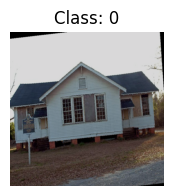

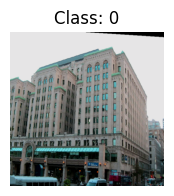

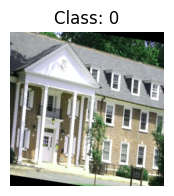

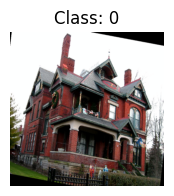

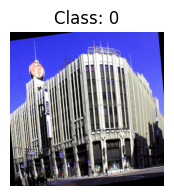

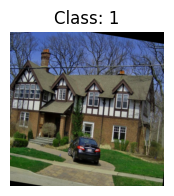

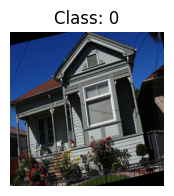

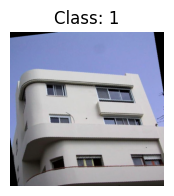

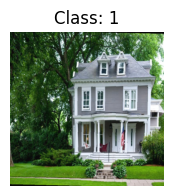

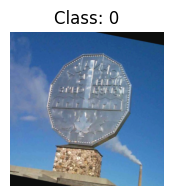

In [8]:
# Function to unnormalize and convert tensor to numpy image
def imshow(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get 10 samples from the augmented training dataset
for i in range(10):
    img, label = train_dataset[i]  
    plt.figure(figsize=(2, 2))
    imshow(img)
    plt.title(f"Class: {label}")
    plt.show()

In [29]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32)

### Model Creation and Training

In [ ]:
class NextViTPotatoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('nextvit_small.bd_ssld_6m_in1k_384', pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, 25)

    def forward(self, x):
        features = self.backbone.forward_features(x)
        features = features.mean(dim=[2, 3])
        return self.backbone.head(features)

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NextViTPotatoClassifier().to(device)

for param in model.parameters():
    param.requires_grad = False  # freeze everything

# Unfreeze only the classifier head
for param in model.backbone.head.parameters():
    param.requires_grad = True


# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.backbone.head.parameters(), lr=4e-3)

In [ ]:
#show trainable parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


In [ ]:
def reset_head_weights(model):
    for layer in model.backbone.head.modules():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()

def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            _, pred_classes = torch.max(probs, dim=1)
            correct += (pred_classes == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
from tqdm import tqdm

# Training loop
reset_head_weights(model)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Show progress bar per epoch
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for imgs, labels in loop:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        train_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

        # Update tqdm status bar
        loop.set_postfix(loss=loss.item())

    train_acc = train_correct / train_total
    val_acc = evaluate(model, val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, 'checkpoint.pth')

### Model Evaluation and Testing

In [ ]:
test_acc = evaluate(model, test_loader)
print(f"Testing Accuracy: {test_acc:.4f}")

### Save Model

In [ ]:
!pip install onnx

In [ ]:
# Export to ONNX
model.eval()
dummy_input = torch.randn(1, 3, 384, 384).to(device)

torch.onnx.export(
    model,
    dummy_input,
    "archinet.onnx",           # output file name
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=16,
    verbose=False,
)